In [9]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [136]:
#assume that vectors of interest are along the last dimension

def softmax(s):
    amax = np.amax(s, axis=0, keepdims=True)
    return amax + np.log(np.sum(np.exp(s - amax), axis=0))

def softargmax(s):
    return np.exp(s - softmax(s))

def hessian(s):
    # only works for 1d input
    p = softargmax(s)
    return np.diag(p) - np.outer(p, p)

def var(p,x):
    average = np.sum(p*x)
    return np.sum(p* x**2) - average**2

def varoperator(p):
    return np.diag(p) - np.outer(p, p)


In [49]:
s = np.random.randn(3)
a = softmax(s)
p = softargmax(s)
H = hessian(s)
print(s)
print(a)
print(p, p.sum())
print(H)
print(np.linalg.det(H[:-1,:-1]))

[-1.63507373 -1.32360758  0.2765193 ]
[ 0.57641319]
[ 0.10953765  0.14956551  0.74089683] 1.0
[[ 0.09753916 -0.01638306 -0.0811561 ]
 [-0.01638306  0.12719567 -0.11081261]
 [-0.0811561  -0.11081261  0.19196872]]
0.012138153884


In [67]:
spectrum, eigvectors = np.linalg.eigh(H)
print(spectrum)
print("condition number ",spectrum[-1]/spectrum[1])
print(eigvectors)

onevec = eigvectors[:,1]
print(np.dot(np.dot(H, onevec), onevec))
print(var(p, onevec))

[  1.39881251e-17   1.24709683e-01   2.91993860e-01]
condition number  2.34138883852
[[-0.57735027  0.76196416 -0.29338931]
 [-0.57735027 -0.63506467 -0.51318566]
 [-0.57735027 -0.12689948  0.80657497]]
0.124709682922
0.124709682922


In [81]:
from simplex import Simplex

In [82]:
simplex = Simplex()

Simplex with resolution 6: 2145 points.


In [137]:
# study the evolution of the condition number in 3-simplex
def smoothness(probas):
    ans = []
    for proba in probas:
        score = np.log(proba + 1e-12)
        eigenvalues, eigenvectors = np.linalg.eigh(hessian(score))
        ans.append(eigenvalues[-1])

    return np.array(ans)

def volume(probas):
    ans = []
    for proba in probas:
        ans.append(np.linalg.det(varoperator(proba)[:-1,:-1]))

    return np.array(ans)

def log_condition_number(probas, cap=2):
    return np.minimum(np.log10(condition_number(probas)), cap)

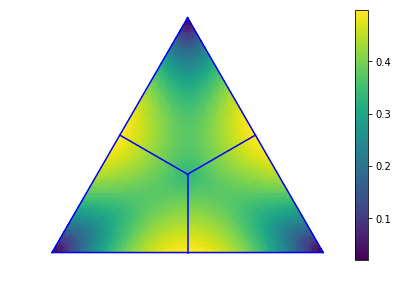

In [138]:
simplex.show_func(smoothness)

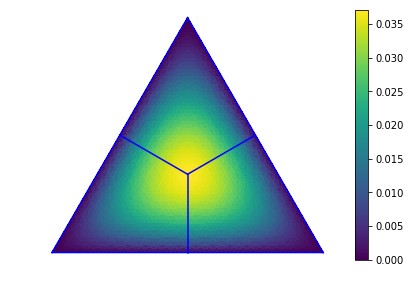

In [139]:
simplex.show_func(volume)

smooth but strongly convex only in a subspace

What are tajectories of gradient descent ? They are straight line in the score space, but what do they look like in the probability space?

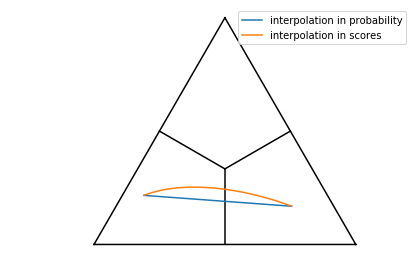

In [135]:
# interpolation line

p1 = 0
p2 = 0
while np.sum((p1-p2)**2) < .3:
    s1 = np.random.randn(3)
    p1 = softargmax(s1)

    s2 = np.random.randn(3)
    p2 = softargmax(s2)
    

interp = np.linspace(0,1,100)[:,np.newaxis]
proba_line = interp*p1 + (1-interp)*p2
score_line = softargmax((interp*s1 + (1-interp)*s2).T).T

# plot
simplex.show_borders(color='black')

cartprobas = simplex.bary2cart(proba_line).T
plt.plot(cartprobas[0], cartprobas[1], label='interpolation in probability')

cartscores = simplex.bary2cart(score_line).T
plt.plot(cartscores[0], cartscores[1], label='interpolation in scores')
plt.legend()
pass